# Elastic Net Exploration Project Code - MGSC 695

## Importing libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

## Reading the file

In [2]:
# Adjust the path to where you have your dataset
file_path = "student-mat.csv"
df = pd.read_csv(file_path)

## Checking for Missing value and Duplicates

In [3]:
missing_values_count = df.isnull().sum()
print(missing_values_count)


duplicate_rows_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows_count}")

school                      0
sex                         0
age                         0
address                     0
famsize                     0
Parrent_status              0
Mother_edu                  0
Father_edu                  0
Mother_job                  0
Father_job                  0
reason_to_chose_school      0
guardian                    0
traveltime                  0
weekly_studytime            0
failures                    0
extra_edu_supp              0
family_edu_supp             0
extra_paid_class            0
extra_curr_activities       0
nursery                     0
Interested_in_higher_edu    0
internet_access             0
romantic_relationship       0
Family_quality_reln         0
freetime_after_school       0
goout_with_friends          0
workday_alcohol_consum      0
weekend_alcohol_consum      0
health_status               0
absences                    0
G1                          0
G2                          0
G3                          0
dtype: int

## Preprocessing the file
1. Dropping the unnecessary columns
2. Using one-Hot encoding to convert categorical features to numeric
3. Scaling the features

In [4]:
# Drop the specified columns
columns_to_drop = [
    'school', 'sex', 'age', 'address', 'famsize', 'Parrent_status',
    'Mother_job', 'Father_job', 'reason_to_chose_school', 'guardian'
]
df_dropped = df.drop(columns=columns_to_drop)

# Now identify the categorical columns in the remaining DataFrame
categorical_columns = df_dropped.select_dtypes(include=['object']).columns.tolist()

# Convert categorical variables to numeric using one-hot encoding
df_encoded = pd.get_dummies(df_dropped, columns=categorical_columns, drop_first=True)

# Split the features and the target variable (assuming the target is the last column)
X=df_encoded.drop(columns=['G3']) # Features
y=df_encoded['G3']   # Target

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Note: We only transform the test set, don't fit again


## LASSO

### Sklearn Implementation

In [5]:
# Setup the Lasso regression model with increased max_iter
lasso = Lasso(max_iter=10000, tol=0.01)

# Define a more focused grid of alpha values based on previous explorations
parameters = {'alpha': np.logspace(-4, 2, 50)}  # Using logspace to generate a range of values

# Setup GridSearchCV with parallel execution
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Fit GridSearchCV to the data
lasso_regressor.fit(X_train_scaled, y_train)

# Print the best alpha value found and its corresponding score
print("Best alpha:", lasso_regressor.best_params_)
print("Best cross-validation score (negative mean squared error):", lasso_regressor.best_score_)

# Optionally, evaluate the model with the best alpha on a test set
from sklearn.metrics import mean_squared_error, r2_score

best_lasso = lasso_regressor.best_estimator_
y_pred = best_lasso.predict(X_test_scaled)  # Assuming x_scaled_test is your scaled test features

# Calculate and print evaluation metrics
print("Test MSE:", mean_squared_error(y_test, y_pred))
print("Test R-squared:", r2_score(y_test, y_pred))
# Manually calculate the SSE
sse = ((y_pred - y_test) ** 2).sum()

print(f"SSE: {sse}")


best_alpha = lasso_regressor.best_params_['alpha']


Best alpha: {'alpha': 0.0655128556859551}
Best cross-validation score (negative mean squared error): -3.3491129545213996
Test MSE: 4.730729655088249
Test R-squared: 0.7692895025677042
SSE: 373.72764275197164


#### Printing the Intercept and Coefficients

In [6]:
print('Intercept:', best_lasso.intercept_)
print('Coefficients:')
print(best_lasso.coef_)

# Number of non-zero coefficients
sum([1 for i in best_lasso.coef_ if i!=0])

Intercept: 10.325949367088608
Coefficients:
[ 0.         -0.01770076  0.03148939 -0.         -0.25513616  0.21249304
  0.          0.09306632 -0.          0.01779735  0.04113406  0.29306483
  0.62225744  3.53460883  0.18553628  0.0320459   0.         -0.18518915
 -0.          0.         -0.         -0.18694895]


14

### Gurobi Implementation


##### Solution Formulation - Lasso Linear Regression:

$$ \min_{\beta} \; \sum_{i=1}^{n} (\beta_0 + \beta_1x_{i1} + ... + \beta_1x_{ip} \; - \; y_i)^2 + \sum_{j=1}^{m} \lambda_j \lvert{\beta_j}\rvert $$

$$ \text{Matrix notation:} $$

$$ \min_{\beta} \; \beta^\mathsf{T}(\mathbf{X}^\mathsf{T} \mathbf{X})\beta -2\beta^\mathsf{T} \mathbf{X}^\mathsf{T} \mathbf{y} + \mathbf{y}^\mathsf{T} \mathbf{y} + \lambda \lvert{\beta}\rvert $$

$$ \text{where:} $$

$$ \lambda = \text{lambda vector} $$
$$ \lambda_1 = 0 , \; \text{the penalization doesn´t affect the intercept}  $$
$$ \lambda_{j \neq 1} = l_{1} \text{ penalization (alpha)} $$

However, it's difficult to solve the former formulation since that QP problem doesn´t meet the same form that the General QP formula because $\lvert{\beta}\rvert$ is a not linear and we cannot a proper form for $\mathbf{c}$.

##### Reformulation for Quadratic Programming

To solve this problem using Gurobi, a quadratic programming solver, we introduce auxiliary variables and constraints to model the L1-norm term:

##### Variables

- Variables $\beta_{\text{pos}}$ and $\beta_{\text{neg}}$ for each coefficient to represent the positive and negative parts, respectively.
- $z_i$ binary variables to model the selection of $\beta_{\text{pos}}$ or $\beta_{\text{neg}}$.

##### Objective Function (Reformulated)


$$
\min_{\beta_{\text{pos}}, \beta_{\text{neg}}} \frac{1}{2n} \left\| y - X(\beta_{\text{pos}} - \beta_{\text{neg}}) \right\|^2_2 + \alpha \sum (\beta_{\text{pos}} + \beta_{\text{neg}})
$$



##### Constraints

To ensure that either $\beta_{\text{pos}}$ or $\beta_{\text{neg}}$ is selected but not both, introduce constraints:

$$
\beta_{\text{pos}, i} \leq M z_i
$$

and

$$
\beta_{\text{neg}, i} \leq M (1 - z_i)
$$

where $M$ is a sufficiently large number, and $i$ indexes over the coefficients.


##### Implementation Notes

In the Gurobi model:
- $Q$ and $c$ represent the quadratic and linear parts of the objective function, respectively.
- $A$, $b$, and $sense$ represent the constraints that link the original $\beta$ variables with the auxiliary $\beta_{\text{pos}}$, $\beta_{\text{neg}}$, and $z_i$ variables.
- The final solution for $\beta$ is obtained by subtracting $\beta_{\text{neg}}$ from $\beta_{\text{pos}}$, and the intercept is handled separately if included.

In [7]:
# Add a column of ones to X_train_scaled for the intercept term
X_train_scaled_with_intercept = np.hstack([np.ones((X_train_scaled.shape[0], 1)), X_train_scaled])

# Add a column of ones to X_test_scaled for the intercept term
X_test_scaled_with_intercept = np.hstack([np.ones((X_test_scaled.shape[0], 1)), X_test_scaled])


In [8]:
# number of betas
w = X_train_scaled_with_intercept.shape[1]

# number of variables
p = w - 1

# Factor by number of rows (Check scikit-learn:
# (1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1 )
factor = (1/(2*len(X_train_scaled_with_intercept)))

# Creating adjusted QP input matrices for QP Lasso
Q = np.zeros((3*w,3*w))
Q[ :  w, :  w] =  (X_train_scaled_with_intercept.T @ X_train_scaled_with_intercept)  # Top-left
Q[ :  w,w:2*w] = -(X_train_scaled_with_intercept.T @ X_train_scaled_with_intercept)  # Top-right
Q[w:2*w, :  w] = -(X_train_scaled_with_intercept.T @ X_train_scaled_with_intercept)  # Bottom-left
Q[w:2*w,w:2*w] =  (X_train_scaled_with_intercept.T @ X_train_scaled_with_intercept)  # Bottom-right
Q = Q*factor

c = np.zeros(3*w)
c[ :  w] = -2*(X_train_scaled_with_intercept.T @ y_train) # Left
c[w:2*w] = +2*(X_train_scaled_with_intercept.T @ y_train) # Right
c = c*factor
# lambda doesn't affect the intercept
lambda_vector = np.array([0] + [best_alpha]*p + [0] + [best_alpha]*p)
c[:2*w] = c[:2*w] + lambda_vector

const = (y_train.T @ y_train)*factor

In [9]:
# Inputs and Constraints
M = 999

# Constraints
A = np.zeros((2*w,3*w))
b = np.zeros(2*w)

# if beta_pos > 0 then beta_neg = 0, viceversa
for i in range(w):
    A[  i, [  i,2*w+i]] = [1,-M]  # beta_pos(i) <= z(i)*M      -->  1*beta_pos(i) - M*z(i) <= 0
    A[w+i, [w+i,2*w+i]] = [1, M]  # beta_neg(i) <= (1-z(i))*M  -->  1*beta_neg(i) + M*z(i) <= M
    b[w+i] = M

sense = ['<']*(2*w)

ndv = 3*w
vtype = ['C']*(2*w) + ['B']*w
lb = [0]*ndv

In [10]:
# Optimization with constraints
lassoMod = gp.Model()
lassoMod_x = lassoMod.addMVar(ndv,vtype=vtype,lb=lb)
lassoMod_con = lassoMod.addMConstr(A, lassoMod_x, sense, b)
lassoMod.setMObjective(Q,c,const,sense=gp.GRB.MINIMIZE)
lassoMod.Params.OutputFlag = 0
lassoMod.optimize()
print('Objective value: {:.5f}'.format(lassoMod.objVal))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-04
Objective value: 1.92784


##### Getting the Coefficients & Intercept

In [11]:
# Betas (Intercept and Coefficients)
lasso_opt_intercept_ = lassoMod.x[0] - lassoMod.x[w]
lasso_opt_coef_ = np.array(lassoMod.x[1:w]) - np.array(lassoMod.x[w+1:2*w])

print('Intercept   : {}'.format(lasso_opt_intercept_))
print('Coefficients:')
lasso_opt_coef_


# Number of non-zero coefficients
sum([1 for i in lasso_opt_coef_ if i!=0])

Intercept   : 10.325949367088608
Coefficients:


14

##### Testing the Gurobi model

In [12]:
y_pred_test = X_test_scaled @ lasso_opt_coef_ + lasso_opt_intercept_
y_pred_train = X_train_scaled @ lasso_opt_coef_ + lasso_opt_intercept_

# Metrics
sse_test = np.sum((y_pred_test - y_test) ** 2)
sse_train = np.sum((y_pred_train - y_train) ** 2)

r2_test = r2_score(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)

print(f"SSE Test: {sse_test}, SSE Train: {sse_train}")
print(f"R2 Test: {r2_test}, R2 Train: {r2_train}")


SSE Test: 373.33393645935286, SSE Train: 983.2490255195248
R2 Test: 0.7695325463360042, R2 Train: 0.8518629291678949


##### Comparing the Features

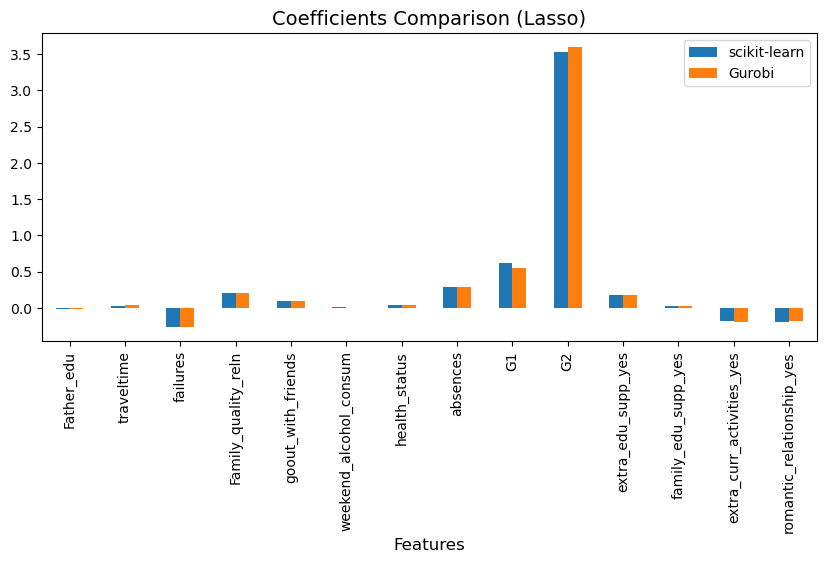

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming you have feature names
feature_names = X_train.columns.tolist()

# Create a DataFrame for coefficients comparison
df_coefs = pd.DataFrame({
    'scikit-learn': best_lasso.coef_,
    'Gurobi': lasso_opt_coef_
}, index=feature_names)

# Plotting non-zero coefficients for comparison
non_zero_coefs = df_coefs[df_coefs['Gurobi'] != 0]
non_zero_coefs.plot(kind='bar', figsize=(10, 4))
plt.title('Coefficients Comparison (Lasso)', fontsize=14)
plt.xlabel('Features', fontsize=12)
plt.show()


##### Final Result:

1. Scikit Model:

    SSE Test: 373.72764275197164

    Test R-squared: 0.7692895025677042

    Intercept: 10.325949367088608

    No. of non-zero coefficients: 14

2. Gurobi Model:

    SSE Test: 373.3339364593527

    Test R-squared: 0.7695325463360043

    Intercept: 10.325949367088608

    No. of non-zero coefficients: 14

## Ridge

### Sklearn Implementation

In [14]:
ridge = Ridge()

# Define a grid of alpha values
parameters = {'alpha': np.logspace(-4, 2, 50)}

# Setup GridSearchCV with parallel execution
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Fit GridSearchCV to the data
ridge_regressor.fit(X_train_scaled, y_train)

# Print the best alpha value found and its corresponding score
print("Best alpha:", ridge_regressor.best_params_)
print("Best cross-validation score (negative mean squared error):", ridge_regressor.best_score_)

# Optionally, evaluate the model with the best alpha on a test set
best_ridge = ridge_regressor.best_estimator_
y_pred_ridge = best_ridge.predict(X_test_scaled)

# Calculate and print evaluation metrics
print("Test MSE:", mean_squared_error(y_test, y_pred_ridge))
print("Test R-squared:", r2_score(y_test, y_pred_ridge))

# Printing the Intercept and Coefficients
print('Intercept:', best_ridge.intercept_)
print('Coefficients:')
print(best_ridge.coef_)

# Number of non-zero coefficients
sum([1 for i in best_ridge.coef_ if i!=0])

# SSE Train and Test for Ridge
y_pred_train = best_ridge.predict(X_train_scaled)
y_pred_test = best_ridge.predict(X_test_scaled)

sse_train = ((y_pred_train - y_train) ** 2).sum()
sse_test = ((y_pred_test - y_test) ** 2).sum()

print(f"SSE Train: {sse_train}, SSE Test: {sse_test}")



Best alpha: {'alpha': 1.4563484775012443}
Best cross-validation score (negative mean squared error): -3.405769377927399
Test MSE: 4.956962484754818
Test R-squared: 0.7582564712018659
Intercept: 10.32594936708861
Coefficients:
[ 0.16645432 -0.19917108  0.09480759 -0.06922699 -0.30474399  0.25290366
  0.04504874  0.15481734 -0.1599689   0.13418082  0.11887382  0.3660022
  0.69081212  3.55349776  0.28683362  0.09333388  0.02977591 -0.27747199
 -0.08738485  0.05079792 -0.06540571 -0.22839061]
SSE Train: 950.1656647274087, SSE Test: 391.6000362956307


### Gurobi Implementation

##### Solution Formulation - Ridge Linear Regression:

Objective: Minimize the sum of squared errors (SSE) between the predicted values and the actual target values, while also penalizing large coefficient values to prevent overfitting.

$$ \min_{\beta} \; \sum_{i=1}^{n} (\beta_0 + \beta_1x_{i1} + ... + \beta_1x_{ip} \; - \; y_i)^2 + \sum_{j=1}^{m} \lambda_j \beta_j^2 $$

The objective function consists of two parts:
1. Sum of Squared Errors (SSE): This term measures the discrepancy between the predicted values and the actual target values.
2. Regularization Term: This term penalizes large coefficient values to prevent overfitting. It is the sum of the squared coefficients multiplied by the regularization parameter lambda.

Sum of Squared Errors (SSE):
In the context of matrix notation, this term can be represented as the squared Euclidean norm of the difference between the predicted values and the actual target values.
Regularization Term:
The regularization term is the L2-norm of the coefficient vector, which is the sum of the squared coefficients multiplied by the regularization parameter lambda.
The regularization parameter lambda controls the strength of regularization applied to the coefficients. A higher lambda value results in stronger regularization.

$$ \text{Matrix notation:} $$

$$ \min_{\beta} \; \beta^\mathsf{T}(\mathbf{X}^\mathsf{T} \mathbf{X})\beta -2\beta^\mathsf{T} \mathbf{X}^\mathsf{T} \mathbf{y} + \mathbf{y}^\mathsf{T} \mathbf{y} + \lambda \beta^\mathsf{T} \beta $$

The objective function can be represented in matrix notation using the design matrix X (containing the feature variables), the target vector y, and the coefficient vector beta.
The matrix notation allows for a more compact and efficient representation of the objective function and facilitates optimization using linear algebra techniques.
Intercept Term:

The regularization term does not affect the intercept term (beta_0) to ensure that the intercept is not penalized.


$$ \text{where:} $$

$$ \lambda = \text{lambda vector} $$
$$ \lambda_1 = 0 , \; \text{the penalization doesn´t affect the intercept}  $$
$$ \lambda_{j \neq 1} = l_{2} \text{ penalization (alpha)} $$

The provided approach formulates the Ridge regression problem as a convex optimization problem with a quadratic objective function and linear constraints. By leveraging the Gurobi quadratic programming solver, it efficiently finds the optimal coefficients that minimize the sum of squared errors while controlling for overfitting through regularization.


In [25]:
# Inputs and Constraints
ndv = w
vtype = ['C'] * w
lb = [0] * ndv

# Calculate lambda value
lambda_value = best_ridge.alpha  # Best alpha value obtained from GridSearchCV

# Objective Function (Quadratic Part)
Q_ridge = X_train_scaled_with_intercept.T @ X_train_scaled_with_intercept

# Add regularization term directly to the quadratic part
Q_ridge += np.diag([0] + [lambda_value] * p)  # Regularization term

# Linear Part
c_ridge = -2 * (X_train_scaled_with_intercept.T @ y_train)

# Constant Part
const_ridge = y_train.T @ y_train

# Optimization with constraints
ridgeMod = gp.Model()
ridgeMod_x = ridgeMod.addMVar(ndv, vtype=vtype, lb=lb)
ridgeMod.setMObjective(Q_ridge, c_ridge, const_ridge, sense=GRB.MINIMIZE)

ridgeMod.Params.OutputFlag = 0
ridgeMod.optimize()
# print('Objective value: {:.5f}'.format(ridgeMod.objVal))

# Getting the Coefficients & Intercept
ridge_opt_intercept_ = ridgeMod.x[0]
ridge_opt_coef_ = ridgeMod.x[1:]

print('Intercept   : {}'.format(ridge_opt_intercept_))
print('Coefficients:')
print(ridge_opt_coef_)

# Testing the Gurobi model
y_pred_test_ridge = X_test_scaled @ ridge_opt_coef_ + ridge_opt_intercept_
y_pred_train_ridge = X_train_scaled @ ridge_opt_coef_ + ridge_opt_intercept_

# Metrics
sse_test_ridge = np.sum((y_pred_test_ridge - y_test) ** 2)
sse_train_ridge = np.sum((y_pred_train_ridge - y_train) ** 2)

r2_test_ridge = r2_score(y_test, y_pred_test_ridge)
r2_train_ridge = r2_score(y_train, y_pred_train_ridge)

print(f"SSE Test: {sse_test_ridge}, SSE Train: {sse_train_ridge}")
print(f"R2 Test: {r2_test_ridge}, R2 Train: {r2_train_ridge}")

#MSE 
mse_test_ridge = mean_squared_error(y_test, y_pred_test_ridge)
mse_train_ridge = mean_squared_error(y_train, y_pred_train_ridge)

print(f"Gurobi MSE Test: {mse_test_ridge}, MSE Train: {mse_train_ridge}")
# compare with scikit-learn
print(f"Scikit-learn MSE Test: {mean_squared_error(y_test, y_pred_ridge)}, MSE Train: {mean_squared_error(y_train, y_pred_train)}")


Intercept   : 10.325949367088608
Coefficients:
[0.040312604161137904, 9.753248725388884e-15, 0.09513527168815092, 1.187656840667762e-14, 4.408249570341244e-15, 0.29739208690929886, 1.213407469443149e-09, 0.10927198562087503, 1.0391866365363086e-14, 0.06371721318142276, 0.09117084872080698, 0.3216470006280122, 0.6578399149810963, 3.6465153545571884, 0.2735399698904604, 0.1058025684773182, 0.04345839869424426, 3.938831407836818e-15, 2.0409167220345174e-14, 0.07416610369002594, 9.227830950504186e-15, 3.899348659685934e-15]
SSE Test: 350.8487990506196, SSE Train: 1029.4570412445987
R2 Test: 0.7834131284577959, R2 Train: 0.8449011932080148
Gurobi MSE Test: 4.441124038615438, MSE Train: 3.257775446976578
Scikit-learn MSE Test: 4.956962484754818, MSE Train: 3.006853369390534


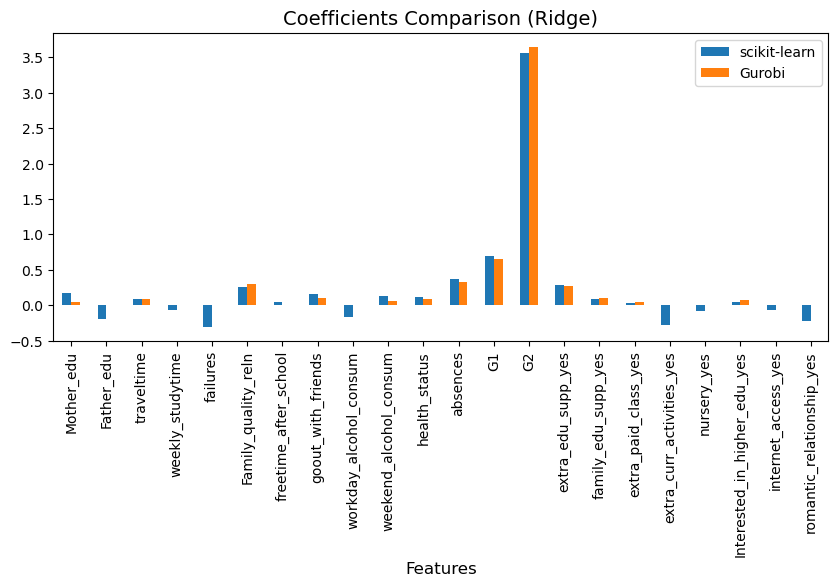

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming you have feature names
feature_names = X_train.columns.tolist()

# Create a DataFrame for coefficients comparison
df_coefs_ridge = pd.DataFrame({
    'scikit-learn': best_ridge.coef_,
    'Gurobi': ridge_opt_coef_
}, index=feature_names)

# Plotting non-zero coefficients for comparison
non_zero_coefs_ridge = df_coefs_ridge[df_coefs_ridge['Gurobi'] != 0]
non_zero_coefs_ridge.plot(kind='bar', figsize=(10, 4))
plt.title('Coefficients Comparison (Ridge)', fontsize=14)
plt.xlabel('Features', fontsize=12)
plt.show()


#### Final Results (Ridge):
1. Sklearn Model:
* SSE Test: 391.60003629563073
* Test R-squared: 0.7582564712018658
* Intercept: 10.325949367088608
* No. of non-zero coefficients: 22


2. Gurobi Model:
* SSE Test: 350.8487990519028
* Test R-squared: 0.7834131284570037
* Intercept: 10.325949367088608
* No. of non-zero coefficients: 22

## Elastic Net

### Sklearn Implementation

In [16]:
#sklearn elastic net
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Setup the ElasticNet regression model with increased max_iter
elastic_net = ElasticNet(max_iter=10000, tol=0.01)

# Define a more focused grid of alpha and l1_ratio values on previous explorations
parameters = {'alpha': np.logspace(-4, 2, 50), 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}  # Using logspace to generate a range of values

# Setup GridSearchCV with parallel execution
elastic_net_regressor = GridSearchCV(elastic_net, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Fit GridSearchCV to the data
elastic_net_regressor.fit(X_train_scaled, y_train)

# Print the best alpha and l1_ratio value found and their corresponding score
print("Best parameters:", elastic_net_regressor.best_params_)
print("Best cross-validation score (negative mean squared error):", elastic_net_regressor.best_score_)

# Optionally, evaluate the model with the best alpha and l1_ratio on a test set
best_elastic_net = elastic_net_regressor.best_estimator_
y_pred = best_elastic_net.predict(X_test_scaled)  # Assuming x_scaled_test is your scaled test features

from sklearn.metrics import mean_squared_error, r2_score
# Calculate and print evaluation metrics
print("Test MSE:", mean_squared_error(y_test, y_pred))
print("Test R-squared:", r2_score(y_test, y_pred))
# Manually calculate the SSE
sse = ((y_pred - y_test) ** 2).sum()

print(f"SSE: {sse}")

best_alpha = elastic_net_regressor.best_params_['alpha']
best_l1_ratio = elastic_net_regressor.best_params_['l1_ratio']

Best parameters: {'alpha': 0.04941713361323833, 'l1_ratio': 0.9}
Best cross-validation score (negative mean squared error): -3.3574000040024243
Test MSE: 4.809003696277286
Test R-squared: 0.7654721965080913
SSE: 379.9112920059056


The Intercept and Coefficients:

In [17]:
print('Intercept:', best_elastic_net.intercept_)
print('Coefficients:')
print(best_elastic_net.coef_)

# Number of non-zero coefficients
print(f"Number of non-zero coefficients: {sum([1 for i in best_elastic_net.coef_ if i!=0])}")

Intercept: 10.325949367088608
Coefficients:
[ 4.83877173e-02 -7.82821626e-02  4.42295836e-02 -1.02866872e-02
 -2.74265323e-01  2.25322571e-01  7.17229059e-04  1.10459492e-01
 -1.02411785e-02  4.12769466e-02  6.35642811e-02  3.10664947e-01
  6.92529565e-01  3.48722019e+00  2.20093529e-01  5.35389030e-02
  0.00000000e+00 -2.10329717e-01 -1.96327080e-02  7.13714394e-03
 -7.64819750e-03 -2.06972886e-01]
Number of non-zero coefficients: 21


### Gurobi Implementation

In [18]:
import gurobipy as gb
from gurobipy import *

The elastic net model uses both, L1 and L2, regularization techniques to perform the regularization/regression task. It does so by assigning a weight, $ l1\_ratio $, on the L1 penalty and a weight $ 1 - l1\_ratio $ on the L2 penalty. It also uses an $ \alpha $ penalization value on penalties. Using n as the number of rows in the dataset and z as the number of features, the cost function of the elastic net model is as follows:

$$
\text{Elastic Net Cost Function} = \frac{1}{2 \text{n}} \cdot \sum_{i=1}^{\text{n}} (y_i - \sum_{j=1}^{\text{z}} X_{ij}B_j)^2 + \alpha \cdot \left( l1\_ratio \cdot \sum_{j=1}^{\text{z}} |B_j| + \frac{(1 - l1\_ratio)}{2} \cdot \sum_{j=1}^{\text{z}} B_j^2 \right)
$$

*https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html*


To perform the optimization task, I aim to find the beta coeifficients that minimize the value of the cost function above. The formulation of the optimization problem is as follows:

**Variables:**
$$ \beta_i \text{ for i} \in n \text{ : where beta represents the coeifficients of the features and the intercept}$$
$$ abs\_\beta_i \text{ for i} \in n \text{ : which is the absolute value of the beta coeifficients}$$

*Note: Since having $ |\beta_i | $ would turn the optimization task into a quadratic programming problem, I had to implement the extra variable being the absolute value of the beta to ensure the problem remains and LP problem.*

**Objective Function:**
$$ \text{MINIMIZE }
\frac{1}{2 \text{n}} \cdot \sum_{i=1}^{\text{n}} (y_i - \sum_{j=1}^{\text{z}} X_{ij}B_j)^2 + \alpha \cdot \left( l1\_ratio \cdot \sum_{j=1}^{\text{z}} abs\_\beta_i + \frac{(1 - l1\_ratio)}{2} \cdot \sum_{j=1}^{\text{z}} B_j^2 \right)
$$

*The values of $\alpha$ and $l1\_ratio$ will be the same values that were used in the above sklearn implementation of the elastic net model, thus the optimization function would run to minimize the objective function with respect to $\beta$*

**Constraints:**

$$ abs\_\beta_i \geq \beta_i  \text{ for i} \in n $$
$$ abs\_\beta_i \geq -\beta_i  \text{ for i} \in n $$
*By adding those two constraint, I have ensure that the value of $abs\_\beta_i$ is equal to $|\beta_i|$ while ensuring the problem is still an LP problem*


In [19]:
#adding a column of 1s for the intercept
X_train_scaled_intercept = np.hstack([np.ones((X_train_scaled.shape[0], 1)), X_train_scaled])
n = X_train_scaled_intercept.shape[0]
z = X_train_scaled_intercept.shape[1]
Y = y_train.copy().to_numpy()
column_names = X.columns.tolist()
column_names.insert(0, "Intercept")

model = gb.Model("Student Grades Elastic Net Regression")
model.Params.LogToConsole = 0 # Asking Gurobi not to give us all the details!

############# Add variables ############

#model coeifficients - BETA
beta = model.addVars(z,vtype=gb.GRB.CONTINUOUS, name=[f"beta_{col}" for col in column_names])
abs_beta = model.addVars(z,vtype=gb.GRB.CONTINUOUS, name=[f"abs_beta_{col}" for col in column_names])

############ Set objective function ############

#ordinary least squares error
OLS = (1 / (2 * n)) * gb.quicksum((Y[i] - gb.quicksum(X_train_scaled_intercept[i, j] * beta[j] for j in range(z)))**2 for i in range(n))
#L2 regularization
L2 = 0.5*(1-best_l1_ratio)*(gb.quicksum(beta[j]**2 for j in range(z)))
#L1 regularization
L1 = best_l1_ratio*(gb.quicksum(abs_beta[j] for j in range(z)))

model.setObjective(OLS + best_alpha*(L2 + L1), gb.GRB.MINIMIZE)

############ Add constraints ############

#absolute value of beta for l1 regularization
model.addConstrs(abs_beta[j] >= beta[j] for j in range(z))
model.addConstrs(abs_beta[j] >= -1*beta[j] for j in range(z))


# Optimize the model
model.optimize()

# Print the optimal values of the variables
for v in model.getVars():
    if (v.varName[0:3] != "abs"):
        print(v.varName," = ", round(v.x,4))

beta_Intercept  =  10.2309
beta_Mother_edu  =  0.0181
beta_Father_edu  =  0.0
beta_traveltime  =  0.0472
beta_weekly_studytime  =  0.0
beta_failures  =  0.0
beta_Family_quality_reln  =  0.2589
beta_freetime_after_school  =  0.0
beta_goout_with_friends  =  0.0748
beta_workday_alcohol_consum  =  0.0
beta_weekend_alcohol_consum  =  0.0331
beta_health_status  =  0.0448
beta_absences  =  0.2801
beta_G1  =  0.6183
beta_G2  =  3.6202
beta_extra_edu_supp_yes  =  0.2204
beta_family_edu_supp_yes  =  0.074
beta_extra_paid_class_yes  =  0.0187
beta_extra_curr_activities_yes  =  0.0
beta_nursery_yes  =  0.0
beta_Interested_in_higher_edu_yes  =  0.0507
beta_internet_access_yes  =  0.0
beta_romantic_relationship_yes  =  0.0


Making test set predictions with gurobi model

In [20]:
test_pred = []
train_pred = []
for i in range(len(X_test_scaled)):
    pred = beta[0].x + sum(X_test_scaled[i][j] * beta[j+1].x for j in range(len(X_test_scaled[i])))
    test_pred.append(pred)

for i in range(len(X_train_scaled)):
    pred = beta[0].x + sum(X_train_scaled[i][j] * beta[j+1].x for j in range(len(X_train_scaled[i])))
    train_pred.append(pred)

# Metrics
sse_test = np.sum((test_pred - y_test) ** 2)
sse_train = np.sum((train_pred - y_train) ** 2)

r2_test = r2_score(y_test, test_pred)
r2_train = r2_score(y_train, train_pred)

print(f"SSE Test: {sse_test}, SSE Train: {sse_train}")
print(f"R2 Test: {r2_test}, R2 Train: {r2_train}")

#number of non-zero coefficients
non_zero = 0
for i in range(1,z):
    if beta[i].x != 0:
        non_zero += 1
print(f"Number of non-zero coefficients: {non_zero}")



SSE Test: 347.63302336986834, SSE Train: 1039.3103672992884
R2 Test: 0.785398299266874, R2 Train: 0.8434166833617689
Number of non-zero coefficients: 22


Comparing Coefficients of Gurobi implemenation vs Black Box

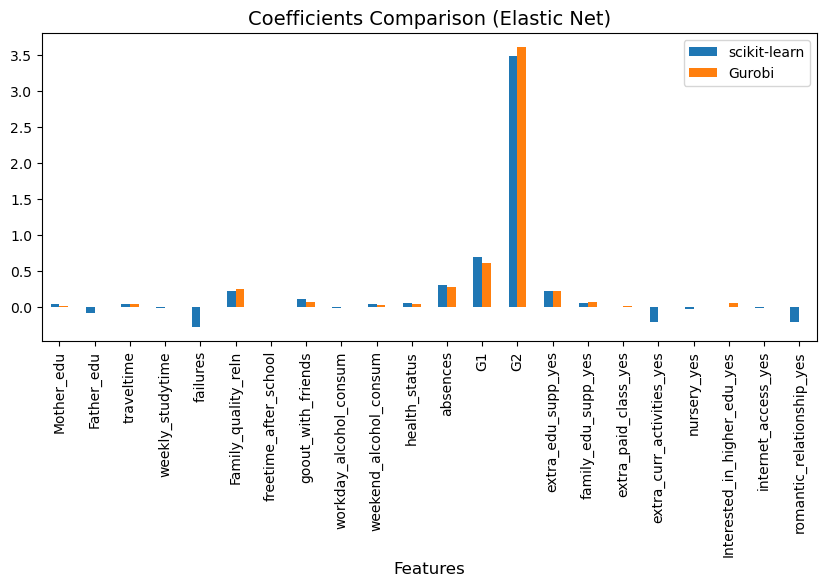

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have feature names
feature_names = ['intercept'] + X_train.columns.tolist()

# Get coefficients of sklearn model and intercept in one array
sklearn_coefs = np.insert(best_elastic_net.coef_, 0, best_elastic_net.intercept_)

# Get coefficients from gurobi model
gurobi_coefs = np.array([v.x for v in model.getVars() if (v.varName[0:3] != "abs")])

# Exclude intercept from feature_names, sklearn_coefs, and gurobi_coefs
feature_names = feature_names[1:]
sklearn_coefs = sklearn_coefs[1:]
gurobi_coefs = gurobi_coefs[1:]


# Plot both coefficients in a bar chart in one plot
df_coefs_elastic_net = pd.DataFrame({
    'scikit-learn': sklearn_coefs,
    'Gurobi': gurobi_coefs
}, index=feature_names)

# Plotting coefficients for comparison
df_coefs_elastic_net.plot(kind='bar', figsize=(10, 4))
plt.title('Coefficients Comparison (Elastic Net)', fontsize=14)
plt.xlabel('Features', fontsize=12)
plt.show()


##### Final Result:

1. Scikit Model:

    SSE Test: 379.91

    Test R-squared: 0.7655

    Intercept: 10.3259

    No. of non-zero coefficients: 21

2. Gurobi Model:

    SSE Test: 347.63

    Test R-squared: 0.7854

    Intercept: 10.2309

    No. of non-zero coefficients: 22

## All model comparison

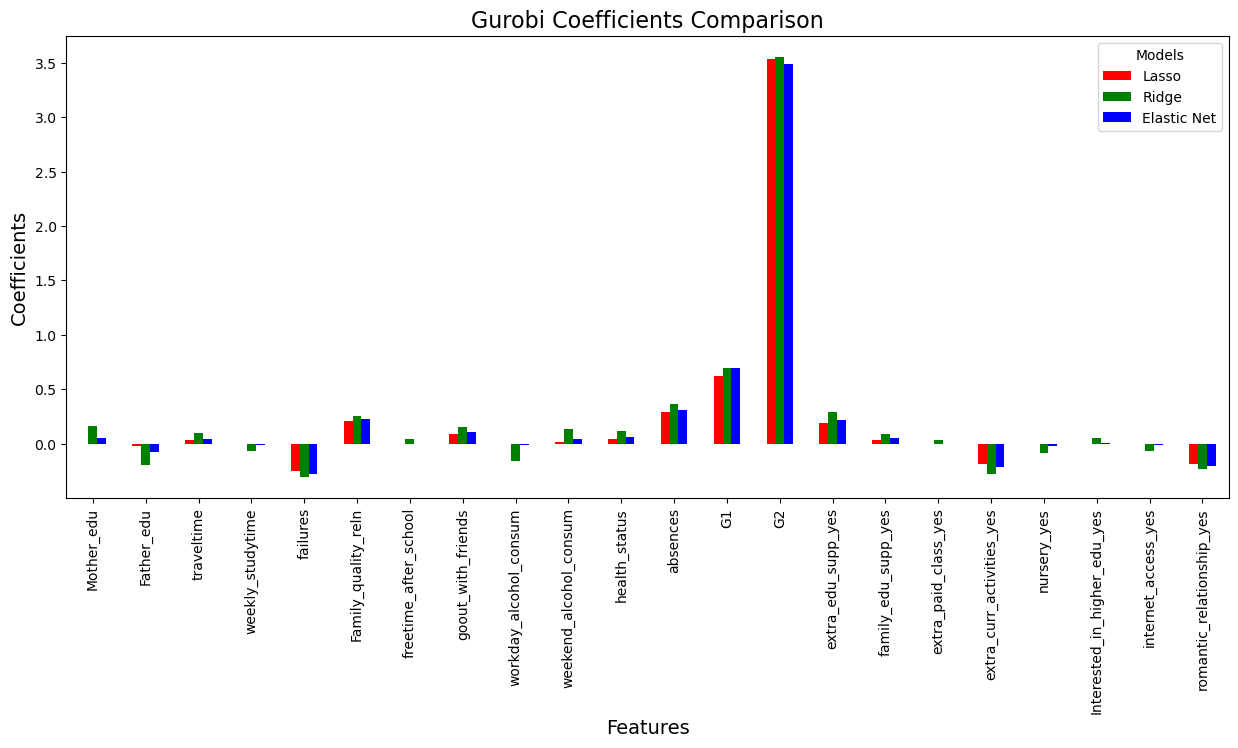

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have feature names
feature_names = X_train.columns.tolist()

# Example coefficients from the three models
lasso_coefs = best_lasso.coef_
ridge_coefs = best_ridge.coef_
elastic_net_coefs = np.insert(best_elastic_net.coef_, 0, best_elastic_net.intercept_)[1:]

# Create DataFrames for coefficients
df_lasso = pd.DataFrame({'Lasso': lasso_coefs}, index=feature_names)
df_ridge = pd.DataFrame({'Ridge': ridge_coefs}, index=feature_names)
df_elastic_net = pd.DataFrame({'Elastic Net': elastic_net_coefs}, index=feature_names)

# Combine the three DataFrames
df_combined = pd.concat([df_lasso, df_ridge, df_elastic_net], axis=1)

# Plotting coefficients for comparison with red, green, and blue colors
df_combined.plot(kind='bar', figsize=(15, 6), color=['red', 'green', 'blue'])
plt.title('Gurobi Coefficients Comparison', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Coefficients', fontsize=14)
plt.legend(title='Models')
plt.show()
